<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
# import common libraries
%load_ext autoreload
%autoreload 2

#%matplotlib notebook
%matplotlib inline

In [2]:
# this is to install lightgbm
#import sys
#!{sys.executable} -m pip install lightgbm

In [3]:
import os
import os.path
import numpy as np
import lightgbm

# Documentation

 - http://lightgbm.readthedocs.io/en/latest/
 - http://lightgbm.readthedocs.io/en/latest/Python-Intro.html
 - https://github.com/Microsoft/LightGBM/tree/master/examples/python-guide

# Train LightGBM and optimize NDCG

In [4]:
# Read dataset from file

train_file = "C:/opt/kiis-training/MSLR-WEB10K/Fold1/train.txt"

if not os.path.exists(train_file) or not os.path.isfile(train_file):
    raise FileNotFoundError("'" + train_file + "': no such file")

In [5]:
from sklearn.datasets import load_svmlight_file
# see http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_svmlight_file.html

train_data = load_svmlight_file(train_file, query_id=True)

In [6]:
print ("X shape:", train_data[0].shape )
print ("Y shape:", train_data[1].shape )
print ("qid shape: ", train_data[2].shape )

X shape: (723412, 136)
Y shape: (723412,)
qid shape:  (723412,)


In [7]:
# Make it a LightGBM dataset

import itertools

query_lens = [ sum( 1 for _ in group ) for key, group in itertools.groupby( train_data[2] )  ]
train_lgb = lightgbm.Dataset(data=train_data[0], label=train_data[1], group=query_lens)


In [8]:
# Set training parameters
# see http://lightgbm.readthedocs.io/en/latest/Parameters.html

params = {
    'objective':'lambdarank', # what to optimize during training
    'max_position': 10,      # threshold used in optimizing lamdarank (NDCG)
    'learning_rate': 0.1,
    'num_leaves': 32,
    'min_data_in_leaf': 5,
    'metric': ['ndcg'],       # what to use/print for evaluation
    'ndcg_eval_at': 10
}    

lgbm_model = lightgbm.train(params, train_lgb, 
                            num_boost_round=100,
                            valid_sets = [train_lgb], 
                            verbose_eval=True)

[1]	training's ndcg@10: 0.401408
[2]	training's ndcg@10: 0.434942
[3]	training's ndcg@10: 0.446326
[4]	training's ndcg@10: 0.448606
[5]	training's ndcg@10: 0.452221
[6]	training's ndcg@10: 0.45713
[7]	training's ndcg@10: 0.460162
[8]	training's ndcg@10: 0.463825
[9]	training's ndcg@10: 0.465957
[10]	training's ndcg@10: 0.468378
[11]	training's ndcg@10: 0.471446
[12]	training's ndcg@10: 0.472822
[13]	training's ndcg@10: 0.475279
[14]	training's ndcg@10: 0.477513
[15]	training's ndcg@10: 0.479316
[16]	training's ndcg@10: 0.481235
[17]	training's ndcg@10: 0.482715
[18]	training's ndcg@10: 0.484564
[19]	training's ndcg@10: 0.485897
[20]	training's ndcg@10: 0.48702
[21]	training's ndcg@10: 0.488034
[22]	training's ndcg@10: 0.489188
[23]	training's ndcg@10: 0.490888
[24]	training's ndcg@10: 0.492652
[25]	training's ndcg@10: 0.493963
[26]	training's ndcg@10: 0.494926
[27]	training's ndcg@10: 0.495937
[28]	training's ndcg@10: 0.497226
[29]	training's ndcg@10: 0.498307
[30]	training's ndcg@10: 

In [9]:
# A more reasonable setting: train/valid/test

import itertools
from sklearn.datasets import load_svmlight_file
# see http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_svmlight_file.html


train_file = "C:/opt/kiis-training/MSLR-WEB10K/Fold1/train.txt"
valid_file = "C:/opt/kiis-training/MSLR-WEB10K/Fold1/vali.txt"
test_file  = "C:/opt/kiis-training/MSLR-WEB10K/Fold1/test.txt"

# train
raw_data = load_svmlight_file(train_file, query_id=True)
query_lens = [ sum( 1 for _ in group ) for key, group in itertools.groupby( raw_data[2] )  ]
train_lgb = lightgbm.Dataset(data=raw_data[0], label=raw_data[1], group=query_lens)

# valid
raw_data = load_svmlight_file(valid_file, query_id=True)
query_lens = [ sum( 1 for _ in group ) for key, group in itertools.groupby( raw_data[2] )  ]
valid_lgb = lightgbm.Dataset(data=raw_data[0], label=raw_data[1], group=query_lens)

# test
raw_data = load_svmlight_file(test_file, query_id=True)
query_lens = [ sum( 1 for _ in group ) for key, group in itertools.groupby( raw_data[2] )  ]
test_lgb = lightgbm.Dataset(data=raw_data[0], label=raw_data[1], group=query_lens)


In [10]:
params = {
    'objective':'lambdarank', # what to optimize during training
    'max_position': 10,      # threshold used in optimizing lamdarank (NDCG)
    'learning_rate': 0.1,
    'num_leaves': 16,
    'min_data_in_leaf': 5,
    'metric': ['ndcg'],       # what to use/print for evaluation
    'ndcg_eval_at': 10
}    

lgbm_info = {}

lgbm_model = lightgbm.train(params, train_lgb, num_boost_round=200,
                            valid_sets   = [train_lgb, valid_lgb, test_lgb], 
                            valid_names  = ["train", "valid", "test"],
                            evals_result = lgbm_info,
                            verbose_eval = 10)


lgbm_info

[10]	train's ndcg@10: 0.454731	valid's ndcg@10: 0.453521	test's ndcg@10: 0.449714
[20]	train's ndcg@10: 0.472029	valid's ndcg@10: 0.468872	test's ndcg@10: 0.464565
[30]	train's ndcg@10: 0.482043	valid's ndcg@10: 0.479383	test's ndcg@10: 0.473963
[40]	train's ndcg@10: 0.489544	valid's ndcg@10: 0.486821	test's ndcg@10: 0.479738
[50]	train's ndcg@10: 0.493693	valid's ndcg@10: 0.491497	test's ndcg@10: 0.483581
[60]	train's ndcg@10: 0.498532	valid's ndcg@10: 0.49377	test's ndcg@10: 0.488233
[70]	train's ndcg@10: 0.502266	valid's ndcg@10: 0.497249	test's ndcg@10: 0.491541
[80]	train's ndcg@10: 0.505209	valid's ndcg@10: 0.499008	test's ndcg@10: 0.494088
[90]	train's ndcg@10: 0.50834	valid's ndcg@10: 0.500427	test's ndcg@10: 0.495585
[100]	train's ndcg@10: 0.510981	valid's ndcg@10: 0.501545	test's ndcg@10: 0.496434
[110]	train's ndcg@10: 0.513746	valid's ndcg@10: 0.503687	test's ndcg@10: 0.497385
[120]	train's ndcg@10: 0.516759	valid's ndcg@10: 0.504289	test's ndcg@10: 0.497605
[130]	train's n

{'train': OrderedDict([('ndcg@10',
               [0.3880354740950056,
                0.42115499604335044,
                0.4289504572979419,
                0.43471873447312936,
                0.4399821489786761,
                0.4457334245575533,
                0.44784036741687183,
                0.44794312834826805,
                0.45340260837872765,
                0.4547309425307871,
                0.4567093370387108,
                0.4585639428448169,
                0.459862461685726,
                0.46203585743481457,
                0.46451369501207185,
                0.4656381606629164,
                0.4673218635510377,
                0.4690978866449766,
                0.4706256831707883,
                0.4720288176815245,
                0.4733175925770162,
                0.47396678886498234,
                0.4752101583610179,
                0.4763630935628876,
                0.47743430835372896,
                0.479030350879089,
                0.4795

Text(0.5, 1.0, 'Model Error')

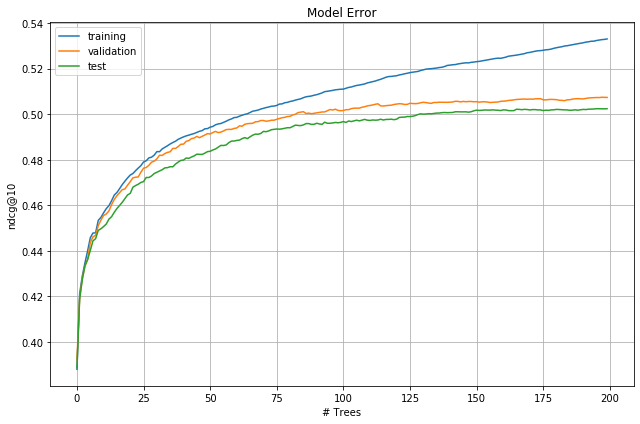

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,6), tight_layout=True)

plt.plot(lgbm_info['train']['ndcg@10'], label='training')
plt.plot(lgbm_info['valid']['ndcg@10'], label='validation')
plt.plot(lgbm_info['test']['ndcg@10'], label='test')

plt.grid()
plt.legend()
plt.xlabel("# Trees")
plt.ylabel("ndcg@10")
plt.title("Model Error")

# Advanced example with custom optimization

Let's optimize MSE which we know well.

- see: https://github.com/Microsoft/LightGBM/blob/master/examples/python-guide/advanced_example.py

In [12]:
# self-defined eval metric
# f(preds: array, train_data: Dataset) -> name: string, value: array, is_higher_better: bool
def mse_eval(preds, train_data):
    labels = train_data.get_label()
    
    avg_mse = 0.5 * np.mean( (labels-preds)**2 )
    
    return 'Custom-MSE', avg_mse, False

In [13]:
params = {
    'objective':'lambdarank', # what to optimize during training
    'max_position': 10,      # threshold used in optimizing lamdarank (NDCG)
    'learning_rate': 0.1,
    'num_leaves': 16,
    'min_data_in_leaf': 5,
    'metric': ['None'], #['ndcg'],       # what to use/print for evaluation
#    'ndcg_eval_at': 10
}    

lgbm_info = {}

lgbm_model = lightgbm.train(params, train_lgb, num_boost_round=100,
                            feval = mse_eval,
                            valid_sets   = [train_lgb, valid_lgb, test_lgb], 
                            valid_names  = ["train", "valid", "test"],
                            evals_result = lgbm_info,
                            verbose_eval = 10)


lgbm_info

[10]	train's Custom-MSE: 0.6095	valid's Custom-MSE: 0.625826	test's Custom-MSE: 0.626744
[20]	train's Custom-MSE: 0.675371	valid's Custom-MSE: 0.691729	test's Custom-MSE: 0.692469
[30]	train's Custom-MSE: 0.734788	valid's Custom-MSE: 0.751574	test's Custom-MSE: 0.752412
[40]	train's Custom-MSE: 0.787525	valid's Custom-MSE: 0.804276	test's Custom-MSE: 0.805704
[50]	train's Custom-MSE: 0.837631	valid's Custom-MSE: 0.85424	test's Custom-MSE: 0.85647
[60]	train's Custom-MSE: 0.882939	valid's Custom-MSE: 0.899638	test's Custom-MSE: 0.902617
[70]	train's Custom-MSE: 0.920988	valid's Custom-MSE: 0.936936	test's Custom-MSE: 0.941383
[80]	train's Custom-MSE: 0.954556	valid's Custom-MSE: 0.970348	test's Custom-MSE: 0.975767
[90]	train's Custom-MSE: 0.984725	valid's Custom-MSE: 0.999924	test's Custom-MSE: 1.00678
[100]	train's Custom-MSE: 1.0107	valid's Custom-MSE: 1.02618	test's Custom-MSE: 1.03378


{'train': OrderedDict([('Custom-MSE',
               [0.5509274220075844,
                0.5547451917077136,
                0.5624084431015011,
                0.5702167044341468,
                0.5759240402100855,
                0.5811575924506083,
                0.5880318153428382,
                0.5956615209954853,
                0.6013565877986442,
                0.6094997575490864,
                0.6164930097317173,
                0.6234388464555041,
                0.6305861966406532,
                0.6372944301470682,
                0.6439595388849645,
                0.65050733892989,
                0.6563187859436899,
                0.6629289779292816,
                0.6690816992082224,
                0.6753705199626104,
                0.6809190574864923,
                0.6878372295880929,
                0.693163900804115,
                0.6991652262808546,
                0.7053671195825736,
                0.7126460090704584,
                0.71799672199

Text(0.5, 1.0, 'Model Error')

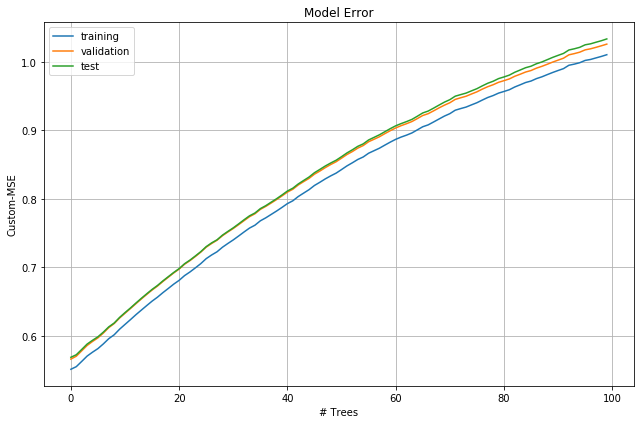

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,6), tight_layout=True)

plt.plot(lgbm_info['train']['Custom-MSE'], label='training')
plt.plot(lgbm_info['valid']['Custom-MSE'], label='validation')
plt.plot(lgbm_info['test']['Custom-MSE'], label='test')

plt.grid()
plt.legend()
plt.xlabel("# Trees")
plt.ylabel("Custom-MSE")
plt.title("Model Error")

In [15]:
# self-defined objective function
# f(preds: array, train_data: Dataset) -> grad: array, hess: array
def mse_grads(preds, train_data):
    labels = train_data.get_label()
    #grad = labels - preds # this is the neg grad !!!
    grad = preds - labels
    hess = np.ones_like(grad)
    return grad, hess

In [16]:
params = {
#    'objective':'lambdarank', # what to optimize during training
#    'max_position': 10,      # threshold used in optimizing lamdarank (NDCG)
    'learning_rate': 0.1,
    'num_leaves': 16,
    'min_data_in_leaf': 5,
    'metric': ['None'], #['ndcg'],       # what to use/print for evaluation
#    'ndcg_eval_at': 10
# try printing ndcg and testing
}    

lgbm_info = {}

lgbm_model = lightgbm.train(params, train_lgb, num_boost_round=100,
                            feval = mse_eval,
                            fobj  = mse_grads,
                            valid_sets   = [train_lgb, valid_lgb, test_lgb], 
                            valid_names  = ["train", "valid", "test"],
                            evals_result = lgbm_info,
                            verbose_eval = 10)


lgbm_info

[10]	train's Custom-MSE: 0.324612	valid's Custom-MSE: 0.335042	test's Custom-MSE: 0.336268
[20]	train's Custom-MSE: 0.290334	valid's Custom-MSE: 0.299707	test's Custom-MSE: 0.300482
[30]	train's Custom-MSE: 0.282394	valid's Custom-MSE: 0.291686	test's Custom-MSE: 0.292361
[40]	train's Custom-MSE: 0.279	valid's Custom-MSE: 0.288329	test's Custom-MSE: 0.289155
[50]	train's Custom-MSE: 0.276912	valid's Custom-MSE: 0.28637	test's Custom-MSE: 0.287461
[60]	train's Custom-MSE: 0.275376	valid's Custom-MSE: 0.285136	test's Custom-MSE: 0.286459
[70]	train's Custom-MSE: 0.274188	valid's Custom-MSE: 0.284176	test's Custom-MSE: 0.285635
[80]	train's Custom-MSE: 0.273134	valid's Custom-MSE: 0.283493	test's Custom-MSE: 0.284916
[90]	train's Custom-MSE: 0.272188	valid's Custom-MSE: 0.282925	test's Custom-MSE: 0.284494
[100]	train's Custom-MSE: 0.271326	valid's Custom-MSE: 0.282435	test's Custom-MSE: 0.284036


{'train': OrderedDict([('Custom-MSE',
               [0.509403454844484,
                0.46891290464905055,
                0.4361490550100102,
                0.4092890660988861,
                0.38743002898143525,
                0.3695353451066708,
                0.35474331023083006,
                0.3427498935844415,
                0.3328196125078314,
                0.32461218303552275,
                0.31784329602221434,
                0.3122633347072416,
                0.30770627543199425,
                0.30388960041081614,
                0.3005847415868324,
                0.2978212228122356,
                0.29547436137985356,
                0.2934690548620616,
                0.29176705005691544,
                0.29033440506591296,
                0.2890645067346179,
                0.28788887003804464,
                0.2868964836308279,
                0.2860347386575127,
                0.2852499946217756,
                0.284552072111267,
                0

Text(0.5, 1.0, 'Model Error')

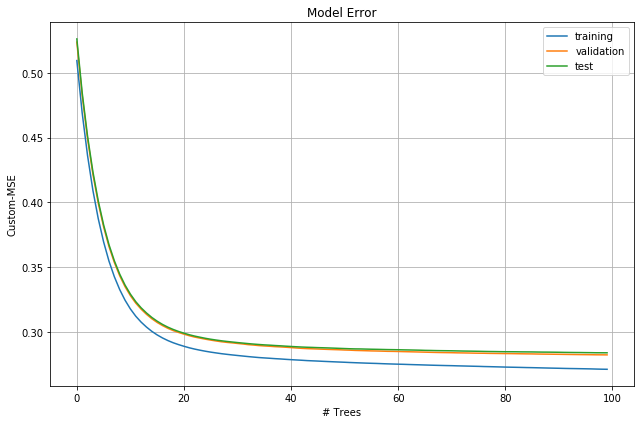

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,6), tight_layout=True)

plt.plot(lgbm_info['train']['Custom-MSE'], label='training')
plt.plot(lgbm_info['valid']['Custom-MSE'], label='validation')
plt.plot(lgbm_info['test']['Custom-MSE'], label='test')

plt.grid()
plt.legend()
plt.xlabel("# Trees")
plt.ylabel("Custom-MSE")
plt.title("Model Error")

# Suggestion

If you want/need to be fast, use cython to implement your objective and evaluation functions.